--- Risk Profiler Quiz ---

Starting the quiz...

Question 1: 1. An investment you made lost 10% of its value in a month. You would:
  a) See it as a potential buying opportunity.
  b) Sell immediately to prevent further losses.
  c) Feel concerned but hold, expecting recovery.
Question 2: 2. When thinking about long-term investments (10+ years), you prioritize:
  a) A balance of growth and safety.
  b) Maximizing potential returns, even with higher risk.
  c) Capital preservation with minimal risk.
Question 3: 3. How comfortable are you with investments that can have significant ups and downs?
  a) Very comfortable; volatility is the price of high returns.
  b) Moderately comfortable if there's potential for good long-term returns.
  c) Very uncomfortable; I prefer stable values.
Question 4: 4. Regarding financial news and market fluctuations, you tend to:
  a) Follow major trends but don't obsess over daily changes.
  b) Avoid it mostly, as it can be unsettling.
  c) Actively track n

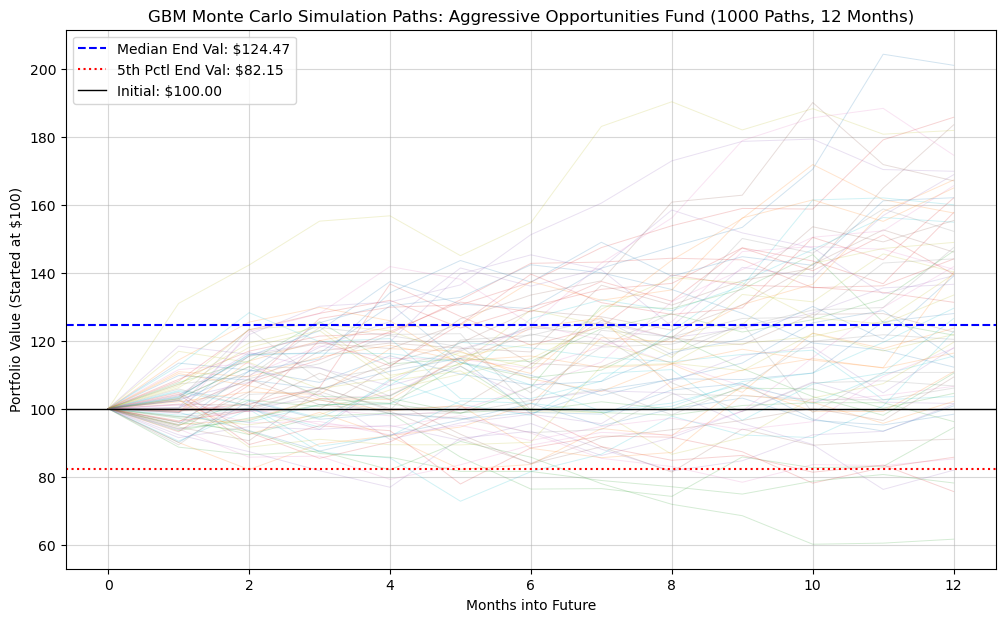

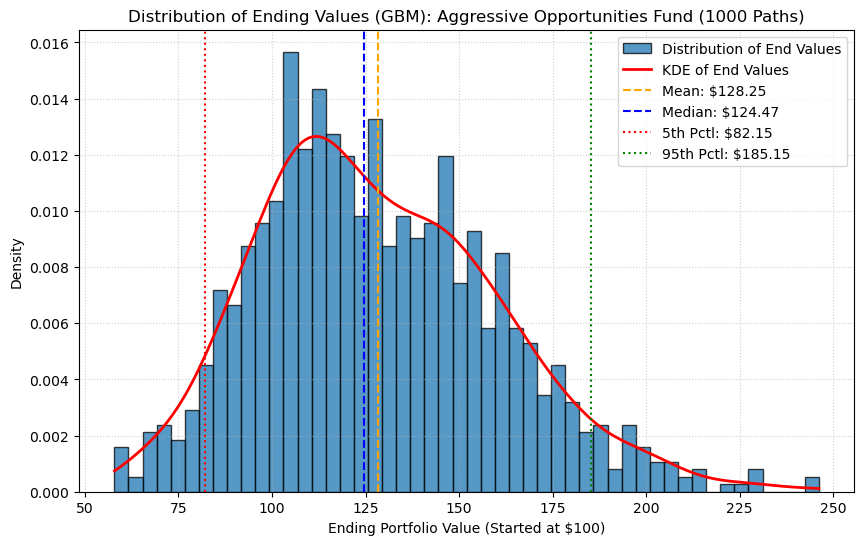


Simulation Statistics (GBM) (based on $100 initial investment from 1000 paths):
  Average Ending Value: $128.25
  Median Ending Value: $124.47
  5th Percentile Ending Value: $82.15
  95th Percentile Ending Value: $185.15
DIAGNOSTIC: For THIS run, 5th Pctl was 82.15, Median was 124.47

  **Note**: This simulation suggests a possibility of noticeable short-term losses.
------------------------------

DIAGNOSTIC: Starting new simulation pass. Check randoms: [0.2905 0.6605 0.7842]
--- Running GBM Stress Test Simulation for: Aggressive Opportunities Fund with 10000 paths ---


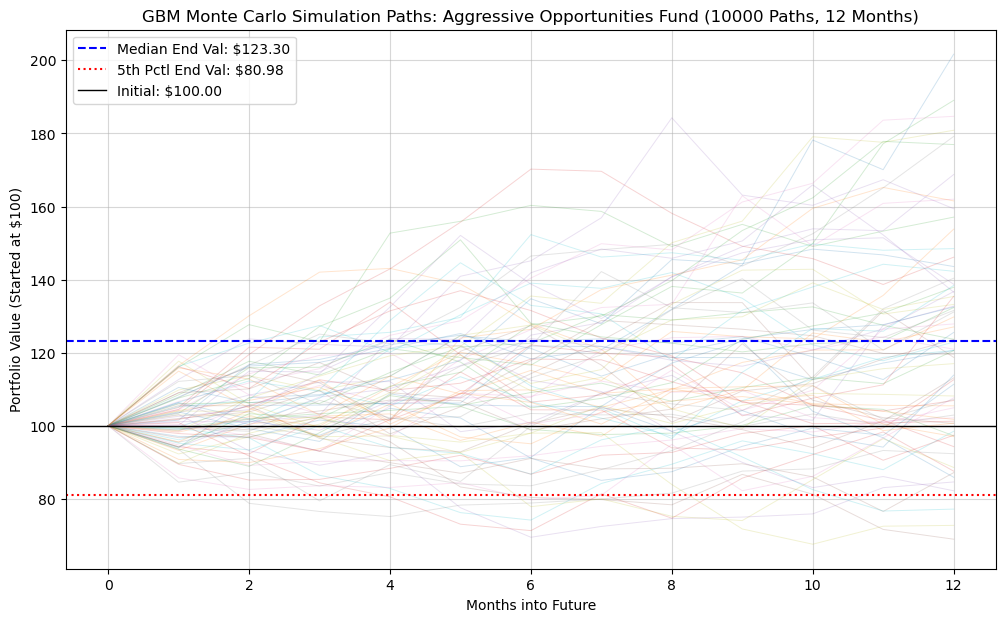

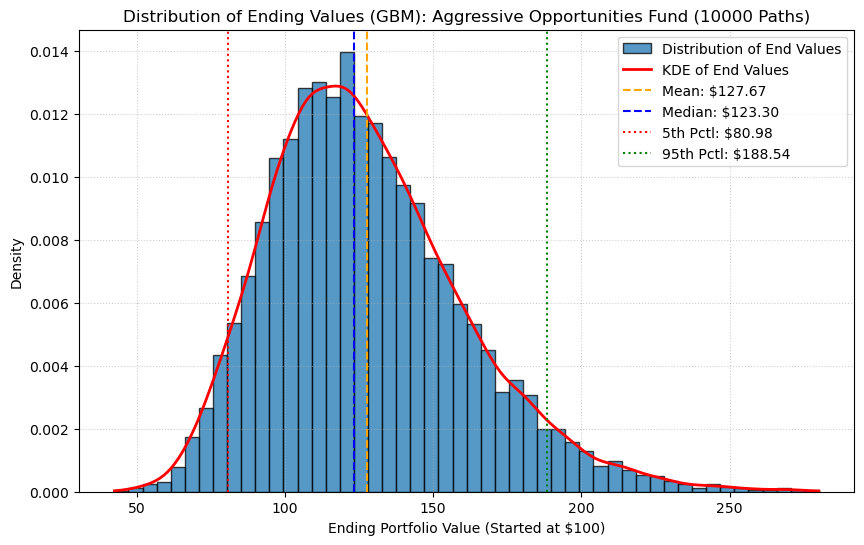


Simulation Statistics (GBM) (based on $100 initial investment from 10000 paths):
  Average Ending Value: $127.67
  Median Ending Value: $123.30
  5th Percentile Ending Value: $80.98
  95th Percentile Ending Value: $188.54
DIAGNOSTIC: For THIS run, 5th Pctl was 80.98, Median was 123.30

  **Note**: This simulation suggests a possibility of noticeable short-term losses.
------------------------------

DIAGNOSTIC: Starting new simulation pass. Check randoms: [0.1884 0.2059 0.6303]
--- Running GBM Stress Test Simulation for: Aggressive Opportunities Fund with 10000 paths ---


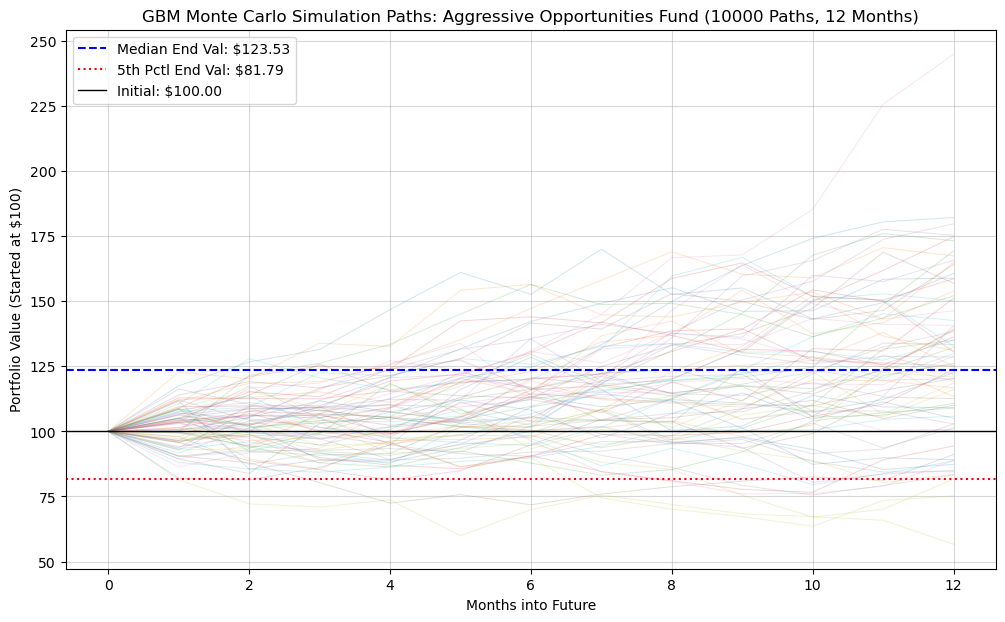

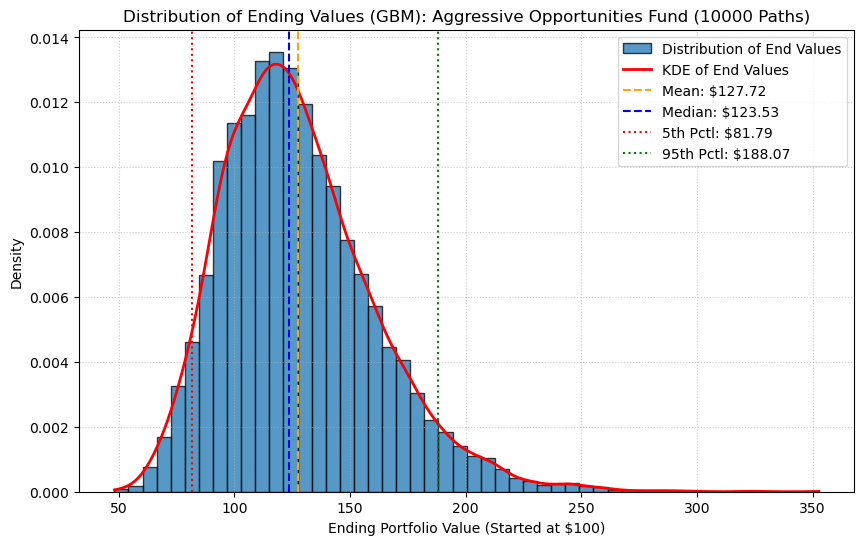


Simulation Statistics (GBM) (based on $100 initial investment from 10000 paths):
  Average Ending Value: $127.72
  Median Ending Value: $123.53
  5th Percentile Ending Value: $81.79
  95th Percentile Ending Value: $188.07
DIAGNOSTIC: For THIS run, 5th Pctl was 81.79, Median was 123.53

  **Note**: This simulation suggests a possibility of noticeable short-term losses.
------------------------------

DIAGNOSTIC: Starting new simulation pass. Check randoms: [0.8168 0.6523 0.925 ]
--- Running GBM Stress Test Simulation for: Aggressive Opportunities Fund with 10000 paths ---


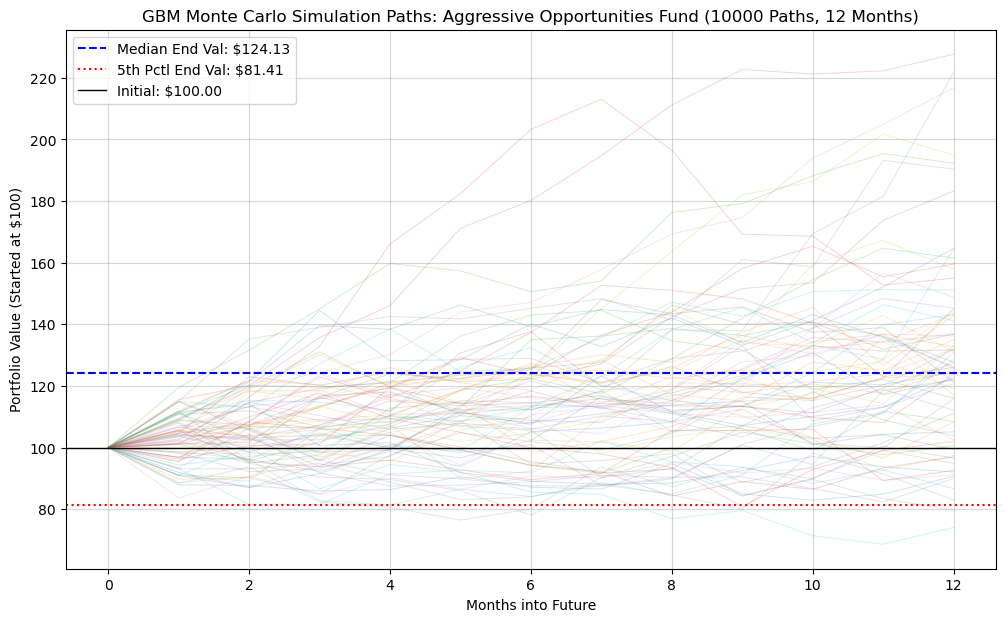

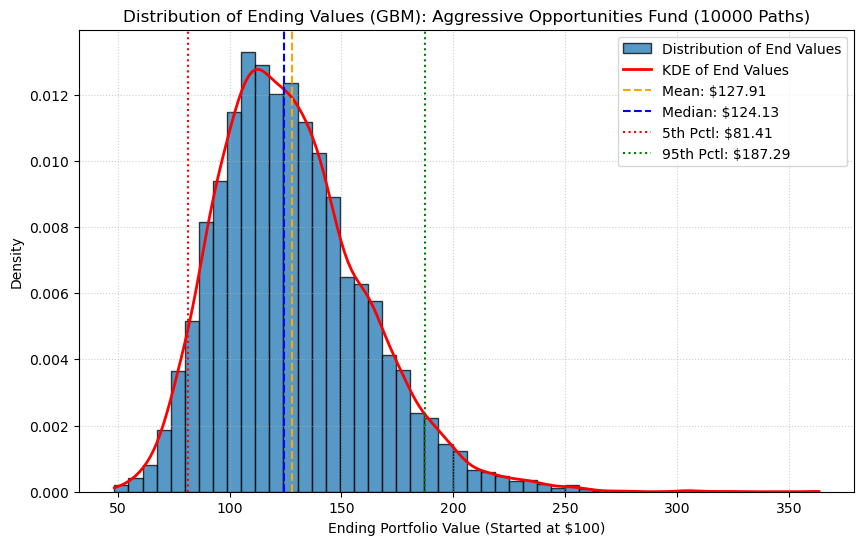


Simulation Statistics (GBM) (based on $100 initial investment from 10000 paths):
  Average Ending Value: $127.91
  Median Ending Value: $124.13
  5th Percentile Ending Value: $81.41
  95th Percentile Ending Value: $187.29
DIAGNOSTIC: For THIS run, 5th Pctl was 81.41, Median was 124.13

  **Note**: This simulation suggests a possibility of noticeable short-term losses.
------------------------------

DIAGNOSTIC: Starting new simulation pass. Check randoms: [0.5764 0.4908 0.3579]
--- Running GBM Stress Test Simulation for: Aggressive Opportunities Fund with 10000 paths ---


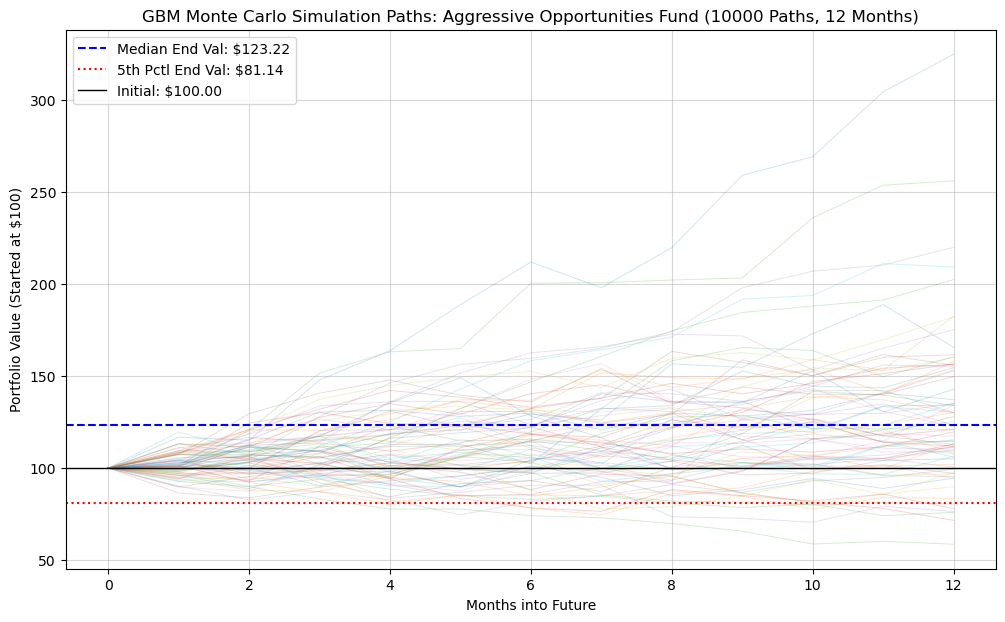

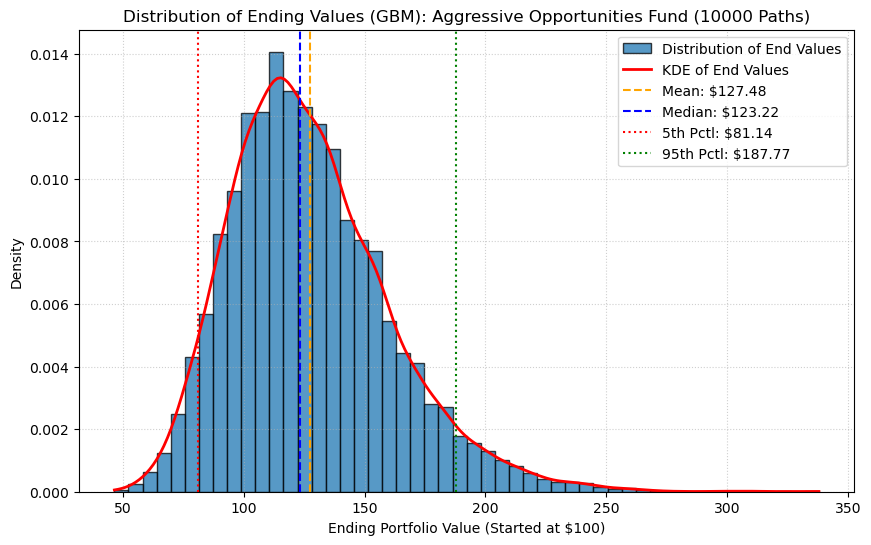


Simulation Statistics (GBM) (based on $100 initial investment from 10000 paths):
  Average Ending Value: $127.48
  Median Ending Value: $123.22
  5th Percentile Ending Value: $81.14
  95th Percentile Ending Value: $187.77
DIAGNOSTIC: For THIS run, 5th Pctl was 81.14, Median was 123.22

  **Note**: This simulation suggests a possibility of noticeable short-term losses.
------------------------------

DIAGNOSTIC: Starting new simulation pass. Check randoms: [0.792  0.9392 0.4678]
--- Running GBM Stress Test Simulation for: Aggressive Opportunities Fund with 10000 paths ---


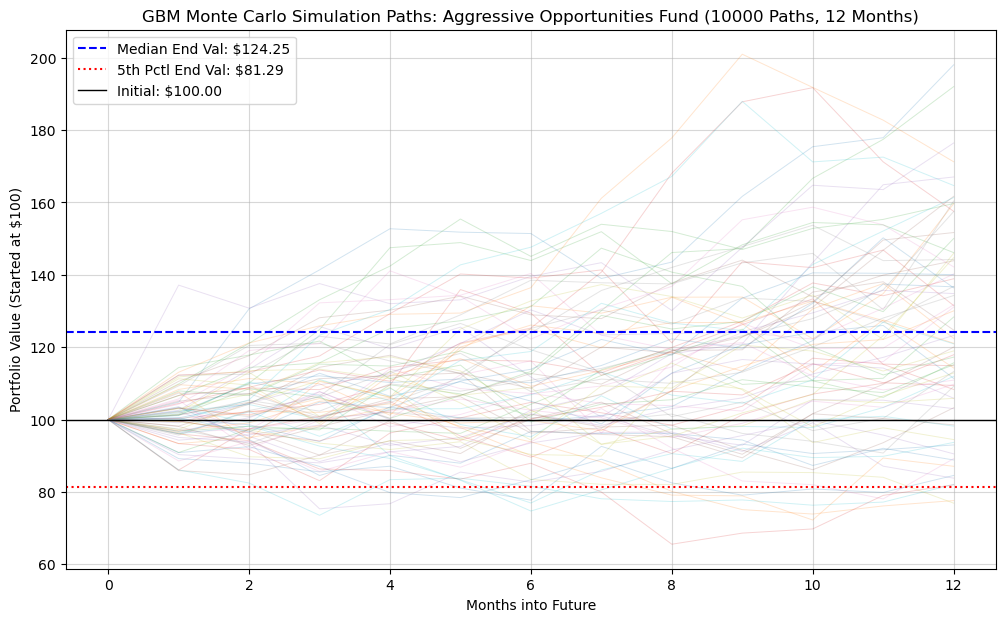

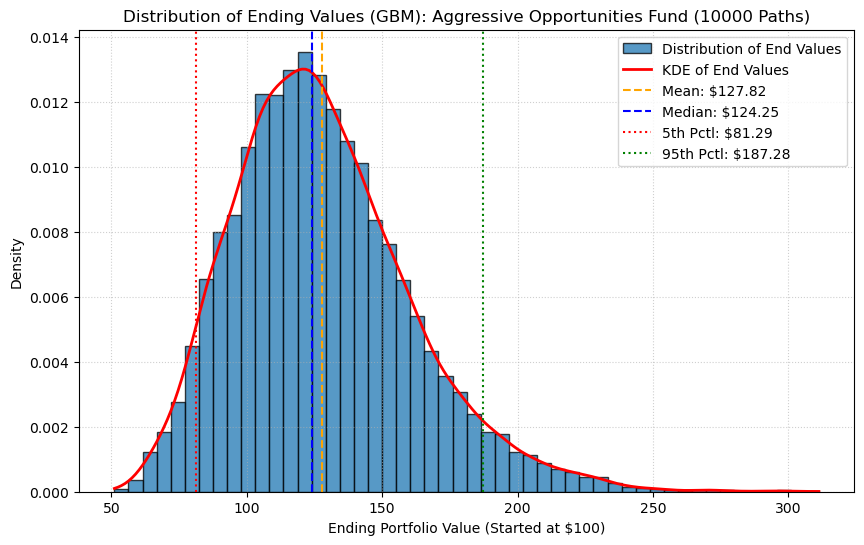


Simulation Statistics (GBM) (based on $100 initial investment from 10000 paths):
  Average Ending Value: $127.82
  Median Ending Value: $124.25
  5th Percentile Ending Value: $81.29
  95th Percentile Ending Value: $187.28
DIAGNOSTIC: For THIS run, 5th Pctl was 81.29, Median was 124.25

  **Note**: This simulation suggests a possibility of noticeable short-term losses.
Not resimulating. Plots from the last run will remain open; please close them manually if desired.

--- End of Game ---
Reflect on how the chosen asset's potential future outcomes (from the stress test)
match your comfort level, given your 'Balanced' risk profile and the asset's historical characteristics.


In [1]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

# --- Game Configuration ---
NUM_ASSETS = 4
NUM_PERIODS_HISTORY = 60  # Corresponds to HIST_PERIODS in your snippet
NUM_SIM_PATHS = 1000
NUM_SIM_PERIODS_FUTURE = 12
MIN_ACCEPTABLE_SAMPLE_MEAN = 0.001 # Corresponds to MIN_MEAN in your snippet

# --- Constants for User's Asset Generation Logic ---
MEAN_STD_RATIO_MIN = 0.10  # Min mean as a fraction of std dev (e.g., mean > 10% of std)
TOLERANCE_FRACTION = 0.35 # Sample stats should be within 35% of target gen stats
FALLBACK_MEAN_MAP = {      # Monthly means for fallback scenarios
    "low": 0.003,          # 0.3% for low volatility archetypes
    "mid": 0.006,          # 0.6% for mid volatility archetypes
    "high": 0.009          # 0.9% for high volatility archetypes
}

# --- Asset Archetypes Definition (Adjusted keys for the new functions) ---
ARCHETYPES = [
    {
        "name": "Conservative Income Fund", # Changed from name_template
        "mean_rng": (0.0025, 0.0055),      # Changed from target_mean_monthly_range
        "std_rng": (0.008, 0.020),        # Changed from target_std_monthly_range
        "dist": "normal",                 # Changed from dist_type
        "skew_rng": (0.0, 0.5),          # Changed from skew_param_range
        "dof_rng": (10, 20)               # Changed from dof_range
    },
    {
        "name": "Balanced Blue Chip Portfolio",
        "mean_rng": (0.005, 0.009),
        "std_rng": (0.020, 0.040),
        "dist": "normal",
        "skew_rng": (-0.3, 0.3),
        "dof_rng": (8, 15)
    },
    {
        "name": "Growth Equity Fund",
        "mean_rng": (0.007, 0.013),
        "std_rng": (0.035, 0.065),
        "dist": "skew_norm", # Changed from skewed_normal for consistency with _draw_returns
        "skew_rng": (-0.5, 1.0),
        "dof_rng": (5, 10) # Though not used if dist is skew_norm
    },
    {
        "name": "Aggressive Opportunities Fund",
        "mean_rng": (0.009, 0.018),
        "std_rng": (0.055, 0.090),
        "dist": "student-t", # Changed from student_t
        "skew_rng": (-1.0, 1.0), # Not used if dist is student-t
        "dof_rng": (4, 7)
    }
]

# --- 1. Risk Profiler Quiz (Assumed stable from previous versions) ---
def run_risk_profiler():
    print("--- Risk Profiler Quiz ---")
    score = 0
    questions_data = [
        {
            "q": "1. An investment you made lost 10% of its value in a month. You would:",
            "options": {"a": "See it as a potential buying opportunity.", "b": "Sell immediately to prevent further losses.", "c": "Feel concerned but hold, expecting recovery."},
            "score_map": {"a": 3, "b": 1, "c": 2}
        },
        {
            "q": "2. When thinking about long-term investments (10+ years), you prioritize:",
            "options": {"a": "A balance of growth and safety.", "b": "Maximizing potential returns, even with higher risk.", "c": "Capital preservation with minimal risk."},
            "score_map": {"a": 2, "b": 3, "c": 1}
        },
        {
            "q": "3. How comfortable are you with investments that can have significant ups and downs?",
            "options": {"a": "Very comfortable; volatility is the price of high returns.", "b": "Moderately comfortable if there's potential for good long-term returns.", "c": "Very uncomfortable; I prefer stable values."},
            "score_map": {"a": 3, "b": 2, "c": 1}
        },
        {
            "q": "4. Regarding financial news and market fluctuations, you tend to:",
            "options": {"a": "Follow major trends but don't obsess over daily changes.", "b": "Avoid it mostly, as it can be unsettling.", "c": "Actively track news for potential opportunities or threats."},
            "score_map": {"a": 2, "b": 1, "c": 3}
        },
        {
            "q": "5. You've received an unexpected bonus. Your first instinct for this money is to:",
            "options": {"a": "Look for a high-growth investment, even if it's speculative.", "b": "Put it mostly into a savings account or very low-risk bonds.", "c": "Split it between savings and some diversified stock investments."},
            "score_map": {"a": 3, "b": 1, "c": 2}
        }
    ]
    print("\nStarting the quiz...\n")
    for q_idx, item_data in enumerate(questions_data):
        print(f"Question {q_idx + 1}: {item_data['q']}")
        option_letters = sorted(item_data["options"].keys())
        for letter in option_letters:
            print(f"  {letter}) {item_data['options'][letter]}")
        while True:
            user_ans_letter = input(f"  Your choice for Q{q_idx + 1} ({', '.join(option_letters)}): ").lower()
            if user_ans_letter in item_data["score_map"]:
                score += item_data["score_map"][user_ans_letter]
                break
            else: print(f"  Invalid input. Please enter one of {', '.join(option_letters)}.")
    if score <= 7: profile = "Conservative"
    elif score <= 12: profile = "Balanced"
    else: profile = "Aggressive"
    print(f"\n--- Your Risk Profile: {profile} ---")
    return profile

# --- 2. Asset Generation (Using User's Provided Logic) ---
def _draw_returns(arch, mean, std, n, rng):
    if arch["dist"] == "normal":
        return rng.normal(mean, std, n)
    if arch["dist"] == "skew_norm": # Matches user's key
        a = rng.uniform(*arch["skew_rng"]) # Assumes skew_rng is a tuple (min_skew, max_skew)
        return stats.skewnorm.rvs(a, loc=mean, scale=std, size=n, random_state=rng)
    # student-t (default if not normal or skew_norm)
    df = int(rng.integers(*arch["dof_rng"])) # Assumes dof_rng is a tuple (min_df, max_df)
    # Ensure df > 2 for defined variance
    safe_df = max(3, df)
    scale = std * np.sqrt((safe_df - 2) / safe_df) if safe_df > 2 else std # Fallback for std if df is too small
    return stats.t.rvs(safe_df, loc=mean, scale=scale, size=n, random_state=rng)

def generate_asset_universe(n_assets=NUM_ASSETS, periods=NUM_PERIODS_HISTORY, seed=None): # Renamed from generate_assets
    rng = np.random.default_rng(seed)
    
    # Use a copy of ARCHETYPES to shuffle locally if needed, or ensure ARCHETYPES itself can be shuffled
    current_archetypes = ARCHETYPES.copy()
    rng.shuffle(current_archetypes)
    assets = []

    for arch in current_archetypes[:n_assets]: # Use n_assets passed to function
        asset_generated_successfully = False
        for _ in range(30):  # 30 retries
            μ_target = rng.uniform(*arch["mean_rng"]) # Target mean for this attempt
            σ_target = rng.uniform(*arch["std_rng"])   # Target std for this attempt
            
            # Sharpe sanity: Ensure target mean is not too low relative to target std
            if σ_target > 0 and μ_target < MEAN_STD_RATIO_MIN * σ_target and μ_target > 0:
                μ_target = MEAN_STD_RATIO_MIN * σ_target
            elif μ_target <= 0: # Ensure target mean is at least slightly positive if it ended up non-positive
                μ_target = MEAN_STD_RATIO_MIN * σ_target if σ_target > 0 else MIN_ACCEPTABLE_SAMPLE_MEAN


            rets = _draw_returns(arch, μ_target, σ_target, periods, rng)
            m_sample, s_sample = rets.mean(), rets.std(ddof=0) # ddof=0 for population-like std of sample

            # Plausibility checks
            mean_ok = (m_sample >= MIN_ACCEPTABLE_SAMPLE_MEAN and
                       (abs(m_sample - μ_target) < TOLERANCE_FRACTION * abs(μ_target) if abs(μ_target) > 1e-6 else abs(m_sample - μ_target) < 0.001)) # Handle near-zero target mean
            
            std_ok = (s_sample > 0 and # Ensure sample std is positive
                      (abs(s_sample - σ_target) < TOLERANCE_FRACTION * σ_target if σ_target > 1e-6 else abs(s_sample - σ_target) < 0.001)) # Handle near-zero target std

            if mean_ok and std_ok:
                assets.append(dict(name=arch["name"], returns=rets,
                                   mean_return=m_sample, # Changed key to match rest of code
                                   std_dev=s_sample,     # Changed key to match rest of code
                                   skewness=stats.skew(rets),
                                   kurtosis=stats.kurtosis(rets),
                                   description=f"Profile: {arch['name']}. TargetGen μ≈{μ_target:.3%}, σ≈{σ_target:.2%}"
                                   ))
                asset_generated_successfully = True
                break
        
        if not asset_generated_successfully:  # fallback
            band = ("low" if arch["std_rng"][1] < 0.02
                    else "mid" if arch["std_rng"][1] < 0.05
                    else "high")
            μ_fb = FALLBACK_MEAN_MAP.get(band, 0.005) # Default fallback mean if band not found
            σ_fb = arch["std_rng"][0] # Use lower bound of archetype's std_rng for fallback std
            if σ_fb <=0: σ_fb = 0.01 # Ensure fallback sigma is positive

            rets_fb = rng.normal(μ_fb, σ_fb, periods)
            m_fb, s_fb = rets_fb.mean(), rets_fb.std(ddof=0)
            assets.append(dict(name=f"{arch['name']} (Fallback)",
                               returns=rets_fb, 
                               mean_return=m_fb, 
                               std_dev=s_fb,
                               skewness=stats.skew(rets_fb), 
                               kurtosis=stats.kurtosis(rets_fb),
                               description=f"Fallback Profile. Gen μ≈{μ_fb:.3%}, σ≈{σ_fb:.2%}"
                               ))
    return sorted(assets, key=lambda a: a["mean_return"])


# --- 3. Display Asset Statistics and Visuals (Assumed stable) ---
def display_assets_info(assets_list):
    if not assets_list: print("No assets available to display."); return
    print("\n--- Investment Opportunities Universe ---")
    max_name_len = 0
    for asset in assets_list:
        if len(asset['name']) > max_name_len: max_name_len = len(asset['name'])
    max_name_len = min(max_name_len, 35) 
    if max_name_len < 20 : max_name_len = 20
    header = f"{'#':<3} {'Name':<{max_name_len}} {'Mean%':>7} {'StdDev%':>9} {'Skew':>8} {'Kurt':>8}"
    print(header); print("-" * len(header))
    for i, asset in enumerate(assets_list):
        mean_pct = asset['mean_return'] * 100; stddev_pct = asset['std_dev'] * 100
        print(f"{i+1:<3} {asset['name']:<{max_name_len}} {mean_pct:>7.2f} {stddev_pct:>9.2f} {asset['skewness']:>8.2f} {asset['kurtosis']:>8.2f}")
    print("-" * len(header))

# --- 4. User Selection (Assumed stable) ---
def get_user_asset_choice(assets_list):
    if not assets_list: return None
    while True:
        try:
            choice = int(input(f"\nEnter the number of the asset you want to analyze further (1-{len(assets_list)}): "))
            if 1 <= choice <= len(assets_list): return assets_list[choice - 1]
            else: print(f"Invalid choice. Please enter a number between 1 and {len(assets_list)}.")
        except ValueError: print("Invalid input. Please enter a number.")

# --- 5. "Stress Test" Monte Carlo Simulation (GBM - Assumed stable) ---
def run_stress_test_simulation(asset, initial_num_paths, num_future_periods):
    monthly_mean_return = asset["mean_return"]
    monthly_std_dev = asset["std_dev"]
    min_monthly_std_dev_for_gbm = 0.0001
    if monthly_std_dev < min_monthly_std_dev_for_gbm:
        print(f"\nWarning: Asset '{asset['name']}' has very low historical volatility ({monthly_std_dev:.4%}).")
        print(f"Using a minimum volatility of {min_monthly_std_dev_for_gbm:.4%} for GBM simulation visuals.")
        monthly_std_dev = min_monthly_std_dev_for_gbm
    annual_mu = monthly_mean_return * 12
    annual_sigma = monthly_std_dev * np.sqrt(12)
    dt = 1.0 / 12.0
    initial_investment = 100
    num_paths_to_run = initial_num_paths
    print(f"\nUsing GBM with Annualized Parameters for {asset['name']}:")
    print(f"  Annualized Expected Return (μ for GBM log-drift): {annual_mu:.3%}")
    print(f"  Annualized Volatility (σ): {annual_sigma:.3%}")
    while True:
        debug_rand_check = np.random.rand(3)
        print(f"\nDIAGNOSTIC: Starting new simulation pass. Check randoms: {np.round(debug_rand_check, 4)}")
        print(f"--- Running GBM Stress Test Simulation for: {asset['name']} with {num_paths_to_run} paths ---")
        simulated_ending_values = []
        plt.figure(figsize=(12, 7))
        paths_to_plot_explicitly = min(75, num_paths_to_run)
        for i in range(num_paths_to_run):
            current_value = initial_investment; path = [current_value]
            for _ in range(num_future_periods):
                Z = np.random.standard_normal()
                drift_term = (annual_mu - 0.5 * annual_sigma**2) * dt
                vol_term = annual_sigma * np.sqrt(dt) * Z
                current_value = current_value * np.exp(drift_term + vol_term)
                current_value = max(current_value, 1e-6)
                path.append(current_value)
            simulated_ending_values.append(current_value)
            if i < paths_to_plot_explicitly : plt.plot(path, lw=0.7, alpha=0.2)
        avg_ending_value = np.mean(simulated_ending_values); median_ending_value = np.median(simulated_ending_values)
        percentile_5th = np.percentile(simulated_ending_values, 5); percentile_95th = np.percentile(simulated_ending_values, 95)
        plt.title(f"GBM Monte Carlo Simulation Paths: {asset['name']} ({num_paths_to_run} Paths, {num_future_periods} Months)")
        plt.xlabel("Months into Future"); plt.ylabel(f"Portfolio Value (Started at ${initial_investment})")
        plt.axhline(median_ending_value, color='blue', linestyle='--', linewidth=1.5, label=f"Median End Val: ${median_ending_value:.2f}")
        plt.axhline(percentile_5th, color='red', linestyle=':', linewidth=1.5, label=f"5th Pctl End Val: ${percentile_5th:.2f}")
        plt.axhline(initial_investment, color='black', linestyle='-', linewidth=1, label=f"Initial: ${initial_investment:.2f}")
        plt.legend(loc='best'); plt.grid(True, alpha=0.5); plt.show(block=False)
        plt.figure(figsize=(10, 6))
        plt.hist(simulated_ending_values, bins=50, alpha=0.75, density=True, edgecolor='black', label="Distribution of End Values")
        try:
            kde_sim = stats.gaussian_kde(simulated_ending_values)
            x_sim_plot = np.linspace(min(simulated_ending_values), max(simulated_ending_values), 200)
            plt.plot(x_sim_plot, kde_sim(x_sim_plot), 'r-', lw=2, label="KDE of End Values")
        except Exception as e: print(f"   Could not generate KDE plot for simulation outcomes: {e}")
        plt.axvline(avg_ending_value, color='orange', linestyle='dashed', linewidth=1.5, label=f"Mean: ${avg_ending_value:.2f}")
        plt.axvline(median_ending_value, color='blue', linestyle='dashed', linewidth=1.5, label=f"Median: ${median_ending_value:.2f}")
        plt.axvline(percentile_5th, color='red', linestyle='dotted', linewidth=1.5, label=f"5th Pctl: ${percentile_5th:.2f}")
        plt.axvline(percentile_95th, color='green', linestyle='dotted', linewidth=1.5, label=f"95th Pctl: ${percentile_95th:.2f}")
        plt.title(f"Distribution of Ending Values (GBM): {asset['name']} ({num_paths_to_run} Paths)")
        plt.xlabel(f"Ending Portfolio Value (Started at ${initial_investment})"); plt.ylabel("Density")
        plt.legend(loc='best'); plt.grid(True, linestyle=':', alpha=0.6); plt.show(block=False)
        print(f"\nSimulation Statistics (GBM) (based on ${initial_investment} initial investment from {num_paths_to_run} paths):")
        print(f"  Average Ending Value: ${avg_ending_value:.2f}")
        print(f"  Median Ending Value: ${median_ending_value:.2f}")
        print(f"  5th Percentile Ending Value: ${percentile_5th:.2f}")
        print(f"  95th Percentile Ending Value: ${percentile_95th:.2f}")
        print(f"DIAGNOSTIC: For THIS run, 5th Pctl was {percentile_5th:.2f}, Median was {median_ending_value:.2f}")
        if percentile_5th < initial_investment * 0.85: print("\n  **Note**: This simulation suggests a possibility of noticeable short-term losses.")
        if percentile_5th < initial_investment * 0.70: print("\n  **Warning**: This asset may show potential for significant drawdowns in adverse scenarios.")
        input("\nView the simulation plots. Press Enter in this console window to continue...")
        resim_choice = input("\nRecalculate (resimulate) this asset? (YES/no, default yes): ").lower()
        if resim_choice in ['no', 'n']:
            print("Not resimulating. Plots from the last run will remain open; please close them manually if desired.")
            break
        else:
            plt.close('all')
            try:
                new_paths_str = input(f"Enter new number of paths for resimulation (current: {num_paths_to_run}, press Enter to keep current): ")
                if new_paths_str:
                    new_paths = int(new_paths_str)
                    if new_paths > 0: num_paths_to_run = new_paths
                    else: print("Number of paths must be positive. Using current value.")
            except ValueError: print("Invalid number. Using current number of paths.")
            print("-" * 30)

# --- Main Game Logic (Assumed stable) ---
def play_asset_explorer_game():
    user_profile = run_risk_profiler()
    print(f"\nAs a reminder, your profile is: {user_profile}")
    input("\nPress Enter to explore investment opportunities...")
    assets = generate_asset_universe(n_assets=NUM_ASSETS, periods=NUM_PERIODS_HISTORY) # Pass named args
    if not assets:
        print("No suitable investment opportunities could be generated. Please try running the game again."); return
    display_assets_info(assets)
    print("\n--- Please refer to the console output for asset numbers ---")
    chosen_asset = get_user_asset_choice(assets)
    if chosen_asset is None:
        print("No asset selected. Exiting game."); return
    print(f"\nYou chose: {chosen_asset['name']}")
    print("Consider if its statistics (mean, std.dev, skewness, kurtosis) align with your risk profile.")
    input(f"\nPress Enter to run a 'Stress Test' Monte Carlo simulation for {chosen_asset['name']}...")
    run_stress_test_simulation(chosen_asset, NUM_SIM_PATHS, NUM_SIM_PERIODS_FUTURE)
    print("\n--- End of Game ---")
    print("Reflect on how the chosen asset's potential future outcomes (from the stress test)")
    print(f"match your comfort level, given your '{user_profile}' risk profile and the asset's historical characteristics.")

if __name__ == "__main__":
    play_asset_explorer_game()